<a href="https://colab.research.google.com/github/trishnakalita660/python_/blob/main/22_(Trishna's_code)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
# Model === 

y_pred_Efficient = []
y_pred_InceptionV3 = []
y_pred_DenseNet = []
y_pred_ResNet = []
y_pred_Ensemble = []

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()


In [5]:
def show_images(tdir):
    classlist=os.listdir(tdir)
    length=len(classlist)
    columns=5
    rows=int(np.ceil(length/columns))    
    plt.figure(figsize=(20, rows * 4))
    for i, klass in enumerate(classlist):    
        classpath=os.path.join(tdir, klass)
        imgpath=os.path.join(classpath, '1.jpg')
        img=plt.imread(imgpath)
        plt.subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title(klass, color='blue', fontsize=12)
        plt.imshow(img)

In [6]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [7]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches, initial_epoch,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting train with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt  or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt ,F to fine tune model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'F' or ans=='f':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

In [8]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


In [38]:
def print_info( test_gen, preds, print_code, save_dir, subject, y_pred_models):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)
    print("y_pred---", y_pred)
    print("y_true--", y_true)
    print("Length of y_pred", len(y_pred))
    print("Length of y_true: Data", len(y_true))
    print(y_true)
    y_pred_models[:] = y_pred

In [10]:
def saver(save_path, model, model_name, subject, accuracy,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color ('model was saved as ' + model_save_loc, (0,255,0),(55,65,80)) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class_dict.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print_in_color ('class csv file was saved as ' + csv_save_loc, (0,255,0),(55,65,80)) 
    return model_save_loc, csv_save_loc

In [11]:
def predictor(sdir, csv_path,  model_path, crop_image = False):    
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_width, img_height)
    scale=class_df['scale by'].iloc[0] 
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1]) 
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)    
    index_list=[] 
    prob_list=[]
    cropped_image_list=[]
    good_image_count=0
    for i in range (image_count):       
        img=cv2.imread(path_list[i])
        if crop_image == True:
            status, img=crop(img)
        else:
            status=True
        if status== True:
            good_image_count +=1
            img=cv2.resize(img, img_size)            
            cropped_image_list.append(img)
            img=img*s2 - s1
            img=np.expand_dims(img, axis=0)
            p= np.squeeze (model.predict(img))           
            index=np.argmax(p)            
            prob=p[index]
            index_list.append(index)
            prob_list.append(prob)
    if good_image_count==1:
        class_name= class_df['class'].iloc[index_list[0]]
        probability= prob_list[0]
        img=cropped_image_list [0] 
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
        plt.imshow(img)
        return class_name, probability
    elif good_image_count == 0:
        return None, None
    most=0
    for i in range (len(index_list)-1):
        key= index_list[i]
        keycount=0
        for j in range (i+1, len(index_list)):
            nkey= index_list[j]            
            if nkey == key:
                keycount +=1                
        if keycount> most:
            most=keycount
            isave=i             
    best_index=index_list[isave]    
    psum=0
    bestsum=0
    for i in range (len(index_list)):
        psum += prob_list[i]
        if index_list[i]==best_index:
            bestsum += prob_list[i]  
    img= cropped_image_list[isave]/255    
    class_name=class_df['class'].iloc[best_index]
    plt.title(class_name, color='blue', fontsize=16)
    plt.axis('off')
    plt.imshow(img)
    return class_name, bestsum/image_count

In [12]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            samples=group.sample(max_size, replace=False, weights=None, random_state=123, axis=0).reset_index(drop=True)
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    balance=list(df[column].value_counts())
    print (balance)
    return df

(224, 224, 3)


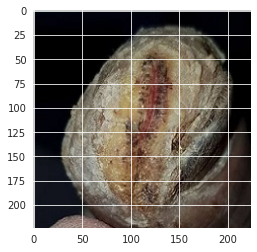

In [15]:
fpath=r'/content/drive/MyDrive/Colab Notebooks/DFU/Patches/Abnormal(Ulcer)/1.jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

In [16]:
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df
    

In [18]:
sdir=r'/content/drive/MyDrive/Colab Notebooks/DFU/Patches/'
train_df, test_df, valid_df= preprocess(sdir, .8,.1)

train_df length:  859   test_df length:  108   valid_df length:  107
Normal(Healthy skin)    434
Abnormal(Ulcer)         425
Name: labels, dtype: int64


In [19]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('labels') # group by class
    for label in train_df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        ndf=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
    else:
        ndf=train_df
    print (list(ndf['labels'].value_counts()) )
    return ndf 
max_samples= 410
min_samples=0
column='labels'
working_dir = r'./'
img_size=(224,224)
ndf=balance(train_df,max_samples, min_samples, column, working_dir, img_size)

[410, 410]
Total Augmented images created=  0
[410, 410]


In [20]:
channels=3
batch_size=30
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  54   test steps:  2
Found 820 validated image filenames belonging to 2 classes.
Found 108 validated image filenames belonging to 2 classes.
Found 107 validated image filenames belonging to 2 classes.


**EfficientNetB3**

In [21]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.EfficientNetB2(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

31801344/31790344 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [22]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     7.099   93.902   9.81188  45.794   0.00100  0.00100  val_loss     0.00    227.72 

 2 /40     5.487   98.415   5.89080  85.981   0.00100  0.00100  val_loss    39.96    22.98  

 3 /40     4.458   98.902   4.47077  96.262   0.00100  0.00100  val_loss    24.11    23.18  

 4 /40     3.713   99.146   3.67041  98.131   0.00100  0.00100  val_loss    17.90    22.91  

 5 /40     3.161   99.390   3.06900  99.065   0.00100  0.00100  val_loss    16.39    23.18  

enter H to halt  or an integer for number of epochs to run then ask again

H
training has been halted at epoch 5 due to user input

Training is completed - model is set with weights from epoch 5 

training elapsed time was 0.0 hours,  6.0 minutes, 9.85 seconds)



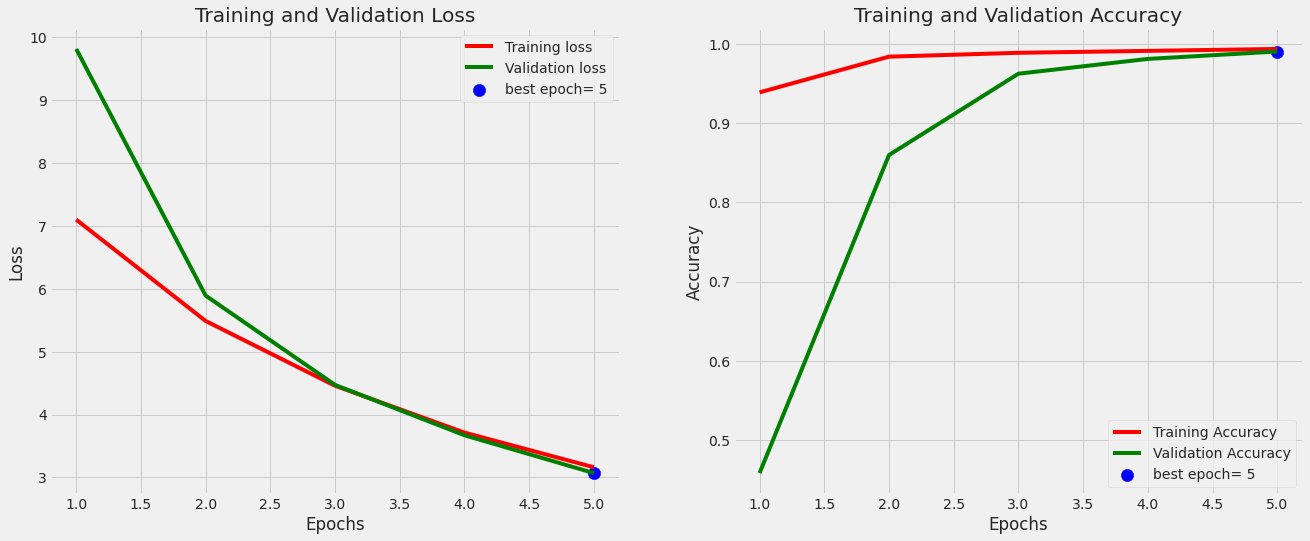

2/2 [==============================] - 13s 11s/step - loss: 3.1310 - accuracy: 0.9722
accuracy on the test set is 97.22 %

model was saved as ./EfficientNetB3-ulcers-97.22.h5

class csv file was saved as ./class_dict.csv



In [23]:
tr_plot(history,0)
subject='ulcers'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model, model_name, subject, acc, img_size, scale,  generator)

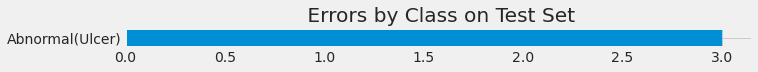

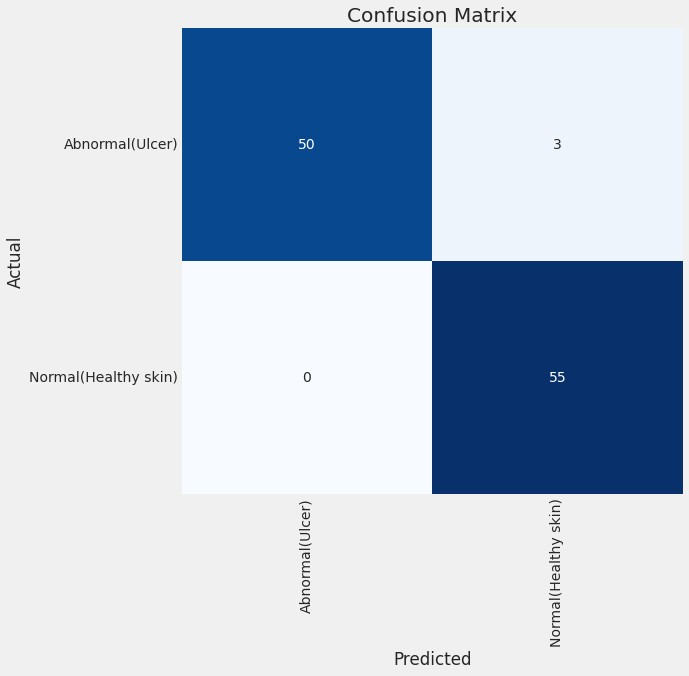

Classification Report:
----------------------
                       precision    recall  f1-score   support

     Abnormal(Ulcer)       1.00      0.94      0.97        53
Normal(Healthy skin)       0.95      1.00      0.97        55

            accuracy                           0.97       108
           macro avg       0.97      0.97      0.97       108
        weighted avg       0.97      0.97      0.97       108

y_pred--- [0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0
 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1]
y_true-- [0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1]
Length of y_pred 108
Length of y_true: Data 108
[0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 

In [39]:

print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject, y_pred_Efficient ) 

In [43]:
y_true= [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,1, 1, 0, 1, 0,
         0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1 ,0,
         1, 0, 1, 0 ,1 ,1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]

print(y_true)
print(len(y_true))

[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
108


****

In [26]:

import cv2
import sys

In [27]:
store_path=os.path.join(working_dir, 'storage')
if os.path.isdir(store_path):
    shutil.rmtree(store_path)
os.mkdir(store_path)
# input an image of an ulcer
img_path=r'/content/drive/MyDrive/Colab Notebooks/DFU/TestSet/1882_19-Effective-Home-Remedies-For-Corns-And-Calluses (1).jpg'
img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# model was trained on rgb images so convert image to rgb
file_name=os.path.split(img_path)[1]
dst_path=os.path.join(store_path, file_name)
cv2.imwrite(dst_path, img)
# check if the directory was created and image stored
print (os.listdir(store_path))

['1882_19-Effective-Home-Remedies-For-Corns-And-Calluses (1).jpg']


 Model is being loaded- this will take about 10 seconds
 image is of class Normal(Healthy skin) with a probability of  53.28 %



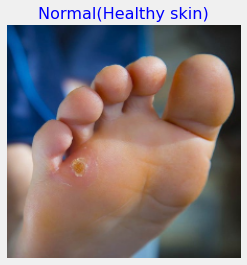

In [28]:
csv_path=csv_save_loc # path to class_dict.csv
model_path=model_save_loc # path to the trained model
class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False) # run the classifier
msg=f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
print_in_color(msg, (0,255,255), (65,85,55))

In [29]:
def print_result(store_path):
  csv_path=csv_save_loc # path to class_dict.csv
  model_path=model_save_loc # path to the trained model
  class_name, probability=predictor(store_path, csv_path,  model_path, crop_image = False) # run the classifier
  msg=f' image is of class {class_name} with a probability of {probability * 100: 6.2f} %'
  print_in_color(msg, (0,255,255), (65,85,55))
  return class_name

In [30]:
import os
def test_model(img_path):
  store_path=os.path.join(working_dir, 'storage')
  if os.path.isdir(store_path):
    shutil.rmtree(store_path)
  os.mkdir(store_path)
  # input an image of an ulcer
  # img_path=r'/content/drive/MyDrive/Colab Notebooks/DFU/TestSet/18.jpg'
  img=cv2.imread(img_path,  cv2.IMREAD_REDUCED_COLOR_2)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # model was trained on rgb images so convert image to rgb
  file_name=os.path.split(img_path)[1]
  dst_path=os.path.join(store_path, file_name)
  cv2.imwrite(dst_path, img)
  # check if the directory was created and image stored
  print (os.listdir(store_path))
  return print_result(store_path)
  
  

['1.jpg']
 Model is being loaded- this will take about 10 seconds
 image is of class Abnormal(Ulcer) with a probability of  95.84 %

['2.jpg']
 Model is being loaded- this will take about 10 seconds
 image is of class Abnormal(Ulcer) with a probability of  99.91 %

['3.jpg']
 Model is being loaded- this will take about 10 seconds
 image is of class Abnormal(Ulcer) with a probability of  94.92 %

['4.jpg']
 Model is being loaded- this will take about 10 seconds
 image is of class Abnormal(Ulcer) with a probability of  98.88 %

['5.jpg']
 Model is being loaded- this will take about 10 seconds
 image is of class Abnormal(Ulcer) with a probability of  80.34 %



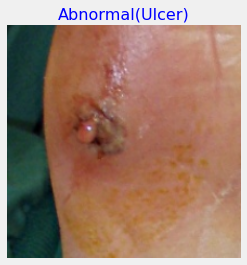

In [31]:
test_folder=r'/content/drive/MyDrive/Colab Notebooks/DFU/TestSet/'
result = []
for x in range(1,6):
  res = test_model(test_folder+str(x)+'.jpg')
  result.append(res)


In [32]:
for x in range(len(result)):
  print(result[x])

Abnormal(Ulcer)
Abnormal(Ulcer)
Abnormal(Ulcer)
Abnormal(Ulcer)
Abnormal(Ulcer)


In [ ]:
diabetic_data = r'/content/drive/MyDrive/Colab Notebooks/DFU/Patches/Abnormal(Ulcer)/'
healthy_data = r'/content/drive/MyDrive/Colab Notebooks/DFU/Patches/Abnormal(Ulcer)/'
Efficient_res = []
Dense_res = []
Inception_res = []

Y_true = [1,1,1,1,1,0,0,0,0,0]

for img in range (1,6):
  res = test_model(diabetic_data+str(img)+'.jpg')
  Efficient_res.append(res)
 
for img in range (100,105):
  res = test_model(healthy_data+str(img)+'.jpg')
  Efficient_res.append(res)

Efficient_pred = []
for x in Efficient_res:
  if x == 'Abnormal(Ulcer)':
    Efficient_pred.append(1)
  else:
    Efficient_pred.append(0)



**INCEPTION V3**

In [33]:
#model2 === InceptionV3
model_name='InceptionV3'
base_model=tf.keras.applications.InceptionV3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model2=Model(inputs=base_model.input, outputs=output)
model2.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

87924736/87910968 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [34]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model2,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model2.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     7.442   92.561  13.47153  58.879   0.00100  0.00100  val_loss     0.00    37.14  

 2 /40     5.582   98.049   7.79369  81.308   0.00100  0.00100  val_loss    42.15    15.46  

 3 /40     4.564   99.024   5.25285  80.374   0.00100  0.00100  val_loss    32.60    15.59  

 4 /40     3.878   99.634   4.04980  87.850   0.00100  0.00100  val_loss    22.90    15.65  

 5 /40     3.381   99.878   3.39508  91.589   0.00100  0.00100  val_loss    16.17    15.61  

enter H to halt  or an integer for number of epochs to run then ask again

H
training has been halted at epoch 5 due to user input

Training is completed - model is set with weights from epoch 5 

training elapsed time was 0.0 hours,  1.0 minutes, 44.25 seconds)



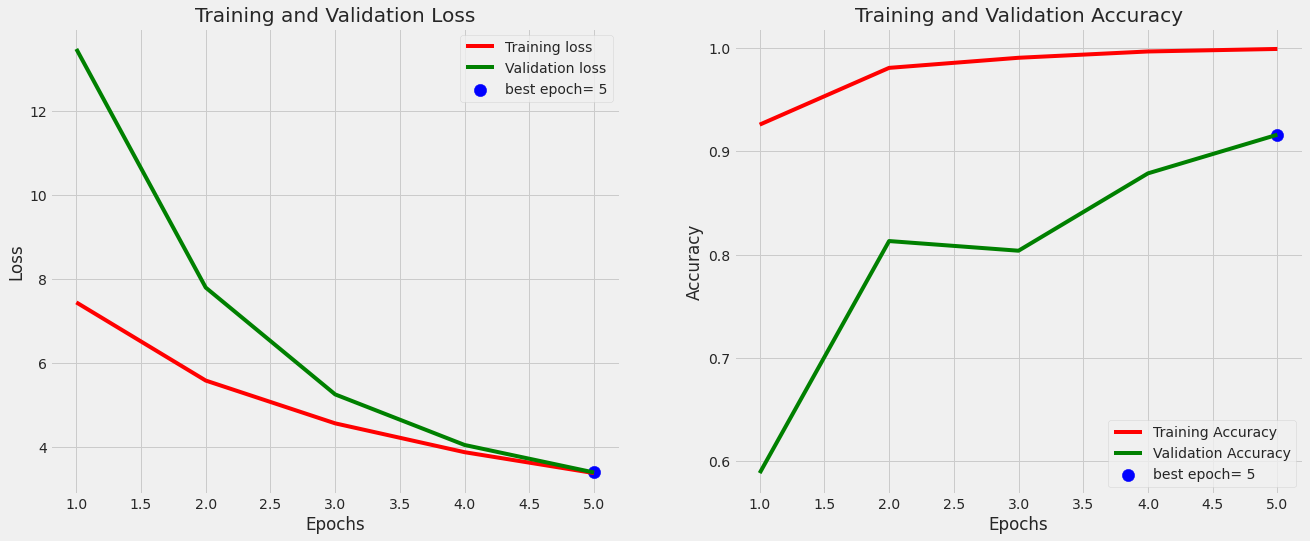

2/2 [==============================] - 3s 251ms/step - loss: 3.3640 - accuracy: 0.9352
accuracy on the test set is 93.52 %

model was saved as ./InceptionV3-ulcers-93.51.h5

class csv file was saved as ./class_dict.csv



In [35]:
tr_plot(history,0)
subject='ulcers'
acc=model2.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model2, model_name, subject, acc, img_size, scale,  generator)

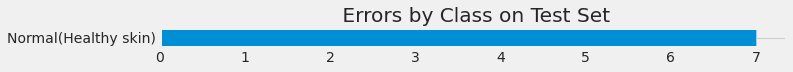

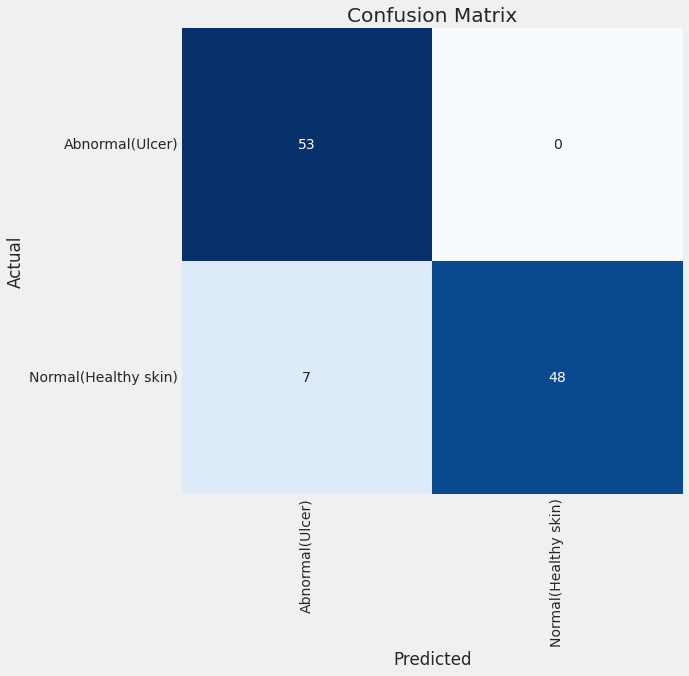

Classification Report:
----------------------
                       precision    recall  f1-score   support

     Abnormal(Ulcer)       0.88      1.00      0.94        53
Normal(Healthy skin)       1.00      0.87      0.93        55

            accuracy                           0.94       108
           macro avg       0.94      0.94      0.94       108
        weighted avg       0.94      0.94      0.93       108

y_pred--- [0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0
 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1]
y_true-- [0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1]
Length of y_pred 108
Length of y_true: Data 108
[0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 

In [41]:
print_code=0
preds=model2.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject,y_pred_InceptionV3) 


***InceptionV3 ROC***

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

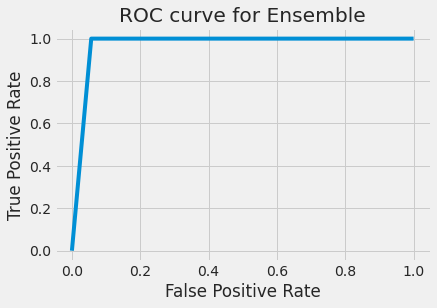

In [44]:

fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_Efficient)

#create ROC curve
plt.plot(fpr,tpr)
plt.title("ROC curve for Ensemble")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
preds1=model2.predict(test_gen)
import cv2
import sys

In [ ]:
test_folder=r'/content/drive/MyDrive/Colab Notebooks/DFU/TestSet/'
result2 = []
for x in range(1,6):
  res = test_model(test_folder+str(x)+'.jpg')
  result.append(res)

In [ ]:
Inception_res = []

Y_true = [1,1,1,1,1,0,1,1,1,1]

for img in range (1,6):
  res = test_model(diabetic_data+str(img)+'.jpg')
  Inception_res.append(res)
for img in range (1,6):
  res = test_model(healthy_data+str(img)+'.jpg')
  Inception_res.append(res)

Inception_pred = []
for x in Inception_res:
  if x == 'Abnormal(Ulcer)':
    Inception_pred.append(1)
  else:
    Inception_pred.append(0)



DENSENET

In [45]:
#model3 === Densenet
model_name='Densenet'
base_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model3=Model(inputs=base_model.input, outputs=output)
model3.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

29097984/29084464 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [46]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model3,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model3.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     6.021   93.415  47.98692  49.533   0.00100  0.00100  val_loss     0.00    59.45  

 2 /40     4.115   97.805  28.06366  54.206   0.00100  0.00100  val_loss    41.52    20.30  

 3 /40     3.143   98.902  11.28977  70.093   0.00100  0.00100  val_loss    59.77    20.33  

 4 /40     2.558   99.634   6.28601  81.308   0.00100  0.00100  val_loss    44.32    20.86  

 5 /40     2.161   100.000  3.82820  85.981   0.00100  0.00100  val_loss    39.10    20.82  

enter H to halt  or an integer for number of epochs to run then ask again

H
training has been halted at epoch 5 due to user input

Training is completed - model is set with weights from epoch 5 

training elapsed time was 0.0 hours,  3.0 minutes, 6.44 seconds)



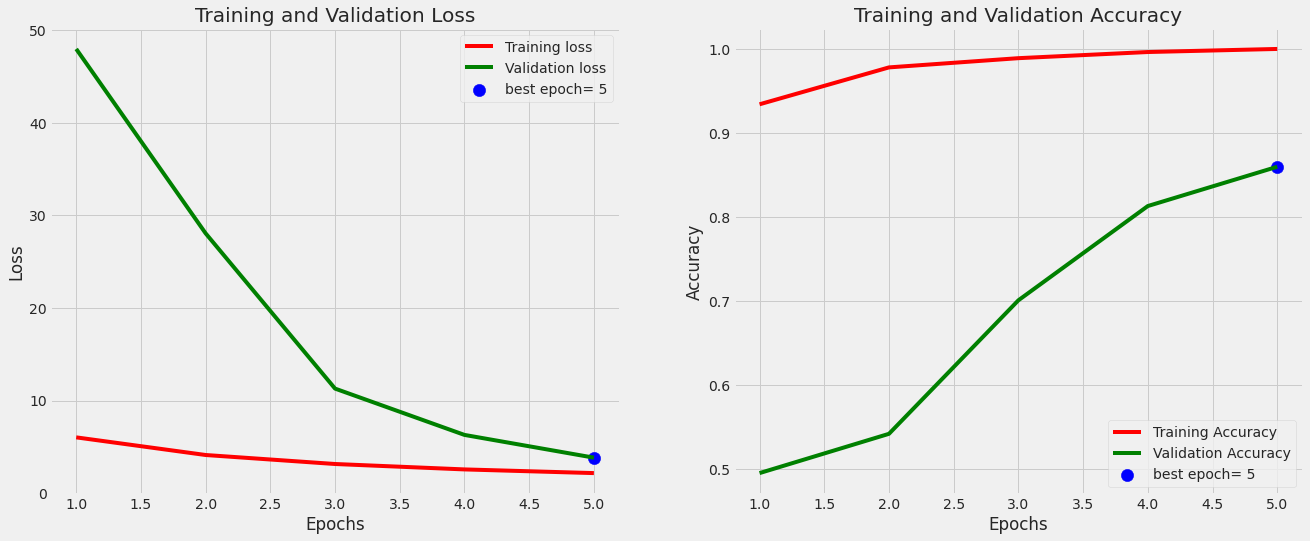

2/2 [==============================] - 3s 304ms/step - loss: 4.1361 - accuracy: 0.8426
accuracy on the test set is 84.26 %

model was saved as ./Densenet-ulcers-84.25.h5

class csv file was saved as ./class_dict.csv



In [47]:
tr_plot(history,0)
subject='ulcers'
acc=model3.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model3, model_name, subject, acc, img_size, scale,  generator)

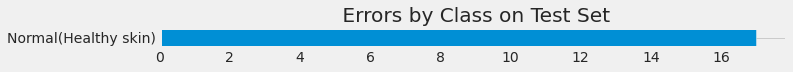

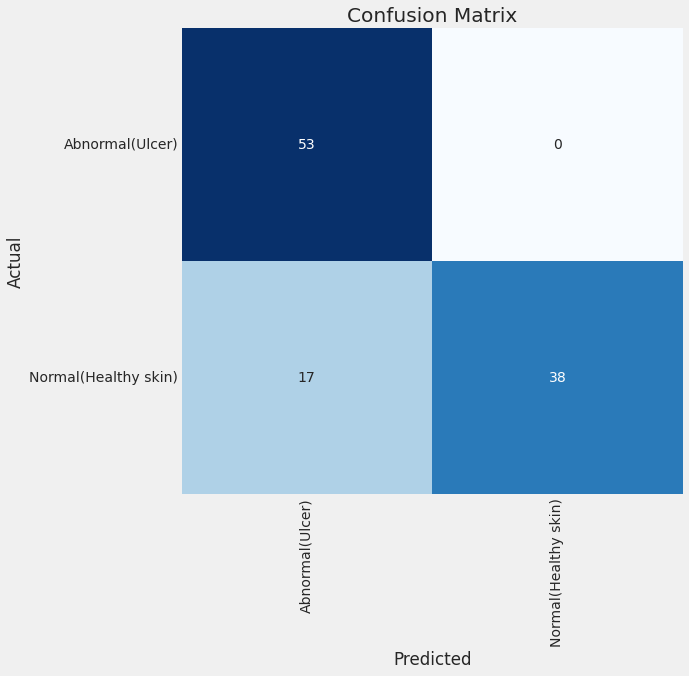

Classification Report:
----------------------
                       precision    recall  f1-score   support

     Abnormal(Ulcer)       0.76      1.00      0.86        53
Normal(Healthy skin)       1.00      0.69      0.82        55

            accuracy                           0.84       108
           macro avg       0.88      0.85      0.84       108
        weighted avg       0.88      0.84      0.84       108

y_pred--- [0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1]
y_true-- [0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1]
Length of y_pred 108
Length of y_true: Data 108
[0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 

In [48]:
print_code=0
preds=model3.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject, y_pred_DenseNet ) 

DENSE NET ROC

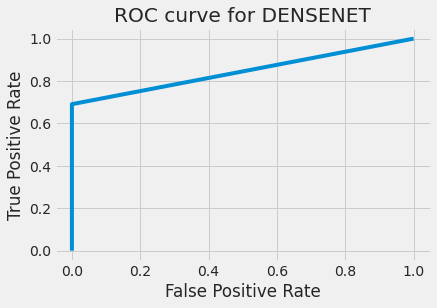

In [65]:
fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_DenseNet)

#create ROC curve
plt.plot(fpr,tpr)
plt.title("ROC curve for DENSENET")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
print(y_pred_DenseNet)
print(len(y_pred_DenseNet))

In [ ]:
test_folder=r'/content/drive/MyDrive/Colab Notebooks/DFU/TestSet/'
result = []
for x in range(1,6):
  res = test_model(test_folder+str(x)+'.jpg')
  result.append(res)


**RESNET**

In [49]:
#model3 === resnet
model_name='resnet'
base_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(class_count, activation='softmax')(x)
model4=Model(inputs=base_model.input, outputs=output)
model4.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [50]:
epochs =40
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
ask_epoch=5 # number of epochs to run before asking if you want to halt training
batches=train_steps
callbacks=[LRA(model=model4,base_model= base_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

history=model4.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)


 initializing callback starting train with base_model trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     6.083   94.146   7.98584  71.028   0.00100  0.00100  val_loss     0.00    35.95  

 2 /40     4.228   97.439   4.33576  90.654   0.00100  0.00100  val_loss    45.71    20.08  

 3 /40     3.268   98.537   3.50196  99.065   0.00100  0.00100  val_loss    19.23    20.08  

 4 /40     2.685   99.634   2.88912  99.065   0.00100  0.00100  val_loss    17.50    20.14  

 5 /40     2.291   99.878   2.40079  100.000  0.00100  0.00100  val_loss    16.90    20.13  

enter H to halt  or an integer for number of epochs to run then ask again

H
training has been halted at epoch 5 due to user input

Training is completed - model is set with weights from epoch 5 

training elapsed time was 0.0 hours,  2.0 minutes, 18.18 seconds)



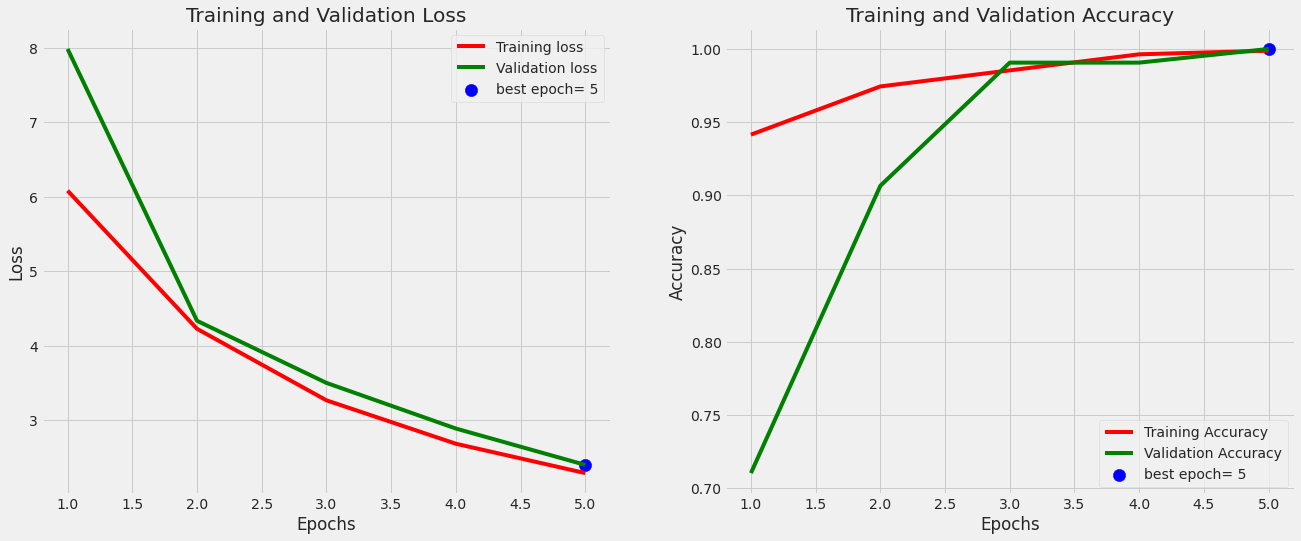

2/2 [==============================] - 1s 329ms/step - loss: 4.1361 - accuracy: 0.8426
accuracy on the test set is 84.26 %

model was saved as ./resnet-ulcers-84.25.h5

class csv file was saved as ./class_dict.csv



In [51]:
tr_plot(history,0)
subject='ulcers'
acc=model4.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
generator=train_gen
scale = 1
model_save_loc, csv_save_loc=saver(working_dir, model4, model_name, subject, acc, img_size, scale,  generator)

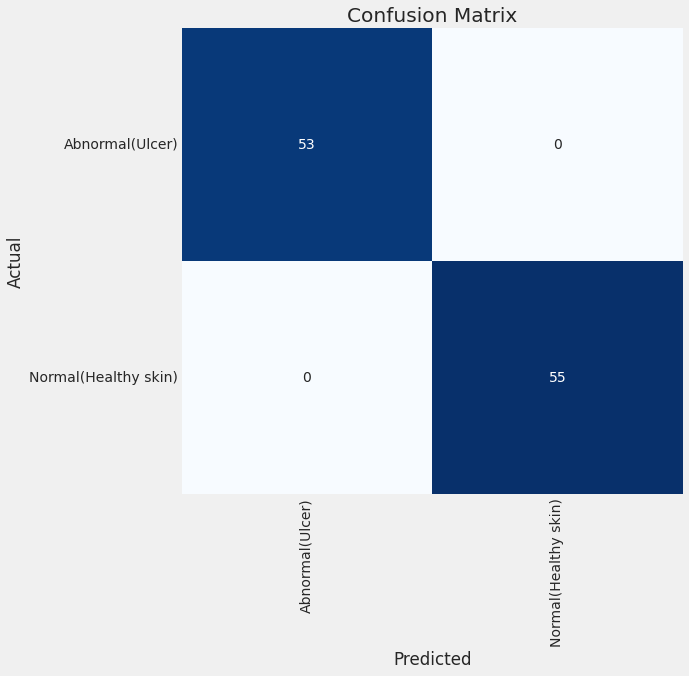

Classification Report:
----------------------
                       precision    recall  f1-score   support

     Abnormal(Ulcer)       1.00      1.00      1.00        53
Normal(Healthy skin)       1.00      1.00      1.00        55

            accuracy                           1.00       108
           macro avg       1.00      1.00      1.00       108
        weighted avg       1.00      1.00      1.00       108

y_pred--- [0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1]
y_true-- [0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1]
Length of y_pred 108
Length of y_true: Data 108
[0 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 

In [77]:
print_code=0
preds=model4.predict(test_gen) 
print_info( test_gen, preds, print_code, working_dir, subject, y_pred_ResNet ) 

In [85]:
y_true= [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,1, 1, 0, 1, 0,
         0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1 ,0,
         1, 0, 1, 0 ,1 ,1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]

print(len(y_true))

108


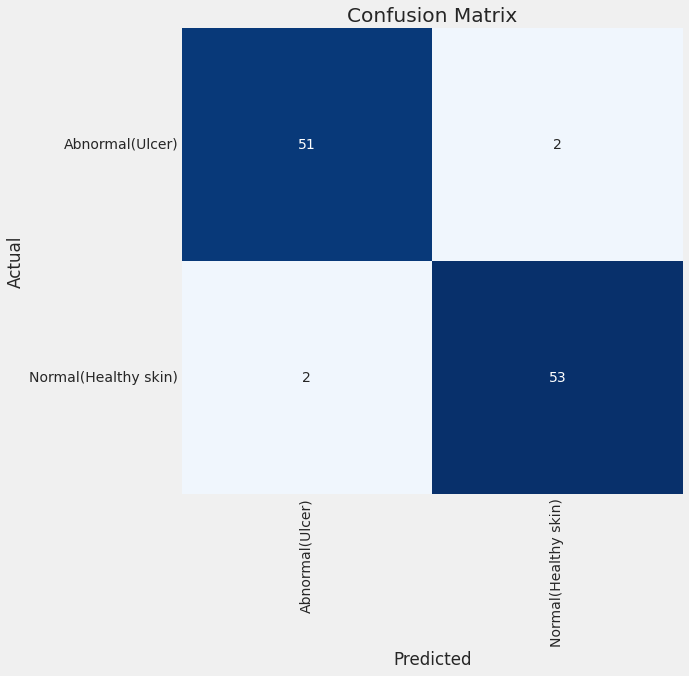

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_pred_ResNet2 = [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]

print_code=0
test = []
# y_true = np.array(test_gen.labels)
# err = abs(y_true-y_pred)
# #print(diff)
# ac2 = 100 - sum(err) / len(y_pred)*100
# #print(ac2)
cm = confusion_matrix(y_true, y_pred_ResNet2)
# disp = ConfusionMatrixDisplay(confusion_matrix = cm)
# disp.plot()

length=2
if length<8:
    fig_width=8
    fig_height=8
else:
    fig_width= int(length * .5)
    fig_height= int(length * .5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

resnet ROC

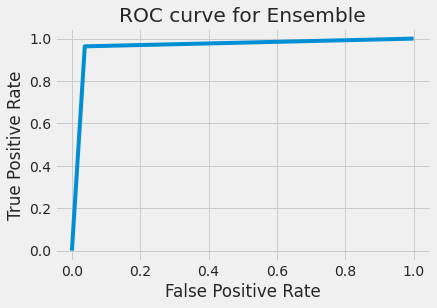

In [89]:
fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_ResNet2)

#create ROC curve
plt.plot(fpr,tpr)
plt.title("ROC curve for Ensemble")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(y_pred_ResNet)
print(len(y_pred_ResNet))

In [ ]:
test_folder=r'/content/drive/MyDrive/Colab Notebooks/DFU/TestSet/'
result = []
for x in range(1,6):
  res = test_model(test_folder+str(x)+'.jpg')
  result.append(res)


**ensemble_pred**

In [ ]:
for x in range(len(y_pred_Efficient)):
  p_count, n_count = 0,0

  if y_pred_Efficient[x] == 0 :
    n_count+=1
  elif y_pred_Efficient[x] == 1 :
    p_count+=1

  if y_pred_InceptionV3[x] == 0 :
    n_count+=1
  elif y_pred_InceptionV3[x] == 1 :
    p_count+=1

  if y_pred_DenseNet[x] == 0 :
    n_count+=1
  elif y_pred_DenseNet[x] == 1 :
    p_count+=1

  if y_pred_ResNet[x] == 0 :
    n_count+=1
  elif y_pred_ResNet[x] == 1 :
    p_count+=1


  if p_count>n_count:
    y_pred_Ensemble.append(1)
  else: 
    y_pred_Ensemble.append(0)


NOT SOLVED

In [ ]:
ensemble_result = []
Y_true = [1,1,1,1,1,0,1,1,1,1]
for x in range(0,10):
  p_count, n_count = 0,0
  if Inception_pred[x] == 0 :
    n_count+=1
  elif Inception_pred[x] == 1 :
    p_count+=1
  if Efficient_pred[x] == 0 :
    n_count+=1
  elif Efficient_pred[x] == 1 :
    p_count+=1
  if Efficient_pred[x] == 0 :
    n_count+=1
  elif Efficient_pred[x] == 1 :
    p_count+=1
  if p_count>n_count:
    ensemble_result.append(1)
  else: 
    ensemble_result.append(0)
print(ensemble_result)
# print("----Ensemble___")
# for x in range(len(ensemble_result)):
#   acc += (Y_true[x] - ensemble_result[x])
# print(100-(acc/len(Y_true)))

err = abs(np.array(Y_true)-np.array(ensemble_result))
print(diff)
ac2 = 100 - sum(err) / len(ensemble_result)*100
print(ac2)


**Ensembled**

In [ ]:
def print_info_ensemble( test_gen, y_pred, print_code, save_dir, subject):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    #y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    # for i, p in enumerate(preds):
    #     pred_index=np.argmax(p)         
    #     true_index=labels[i]  # labels are integer values
    #     if pred_index != true_index: # a misclassification has occurred
    #         error_list.append(file_names[i])
    #         true_class.append(new_dict[true_index])
    #         pred_class.append(new_dict[pred_index])
    #         prob_list.append(p[pred_index])
    #         error_indices.append(true_index)            
    #         errors=errors + 1
    #     y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    #y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
#Getting the y_pred_Efficient using Max Voting algorithm
def get_y_pred_Ensemble():
  for x in range(0,len(y_pred_Efficient)):
    p_count, n_count = 0,0
    y_pred_Ensemble = []
    if y_pred_Efficient[x] == 0 :
      n_count+=1
    elif y_pred_Efficient[x] == 1 :
      p_count+=1

    if y_pred_InceptionV3[x] == 0 :
      n_count+=1
    elif y_pred_InceptionV3[x] == 1 :
      p_count+=1

    if y_pred_DenseNet[x] == 0 :
      n_count+=1
    elif y_pred_DenseNet[x] == 1 :
      p_count+=1

    if y_pred_ResNet[x] == 0 :
      n_count+=1
    elif y_pred_ResNet[x] == 1 :
      p_count+=1


    if p_count>n_count:
      y_pred_Ensemble.append(1)
    else: 
      y_pred_Ensemble.append(0)
  return y_pred_Ensemble

  
  # print("----Ensemble___")
  # for x in range(len(ensemble_result)):
  #   acc += (Y_true[x] - ensemble_result[x])
  # print(100-(acc/len(Y_true)))

  err = abs(np.array(Y_true)-np.array(ensemble_result))
  #print(diff)
  ac2 = 100 - sum(err) / len(ensemble_result)*100
  print(ac2)

In [ ]:
print_code=0
y_pred=get_y_pred_Ensemble()
print(y_pred) 
y_true = np.array(test_gen.labels)
err = abs(y_true-y_pred)
#print(diff)
ac2 = 100 - sum(err) / len(y_pred)*100
#print(ac2)
print_info( test_gen, preds, print_code, working_dir, subject, y_pred_ResNet )

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

In [ ]:
y_pred = [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
y_true = [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]


fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.title("ROC curve for Ensemble")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




ENSEMBLE **NEW**

In [90]:

y_pred_Ensemble = []
for x in range(0,len(y_pred_Efficient)):
  p_count, n_count = 0,0
  if y_pred_Efficient[x] == 0 :
    n_count+=1
  elif y_pred_Efficient[x] == 1 :
    p_count+=1

  if y_pred_InceptionV3[x] == 0 :
    n_count+=1
  elif y_pred_InceptionV3[x] == 1 :
    p_count+=1

  if y_pred_DenseNet[x] == 0 :
    n_count+=1
  elif y_pred_DenseNet[x] == 1 :
    p_count+=1

  if y_pred_ResNet[x] == 0 :
    n_count+=1
  elif y_pred_ResNet[x] == 1 :
    p_count+=1


  if p_count>n_count:
    y_pred_Ensemble.append(1)
  else: 
    y_pred_Ensemble.append(0)

print(y_pred_Ensemble)
  # print("----Ensemble___")
  # for x in range(len(ensemble_result)):
  #   acc += (Y_true[x] - ensemble_result[x])
  # print(100-(acc/len(Y_true)))

  # err = abs(np.array(Y_true)-np.array(ensemble_result))
  # #print(diff)
  # ac2 = 100 - sum(err) / len(ensemble_result)*100
  # print(ac2)

[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]


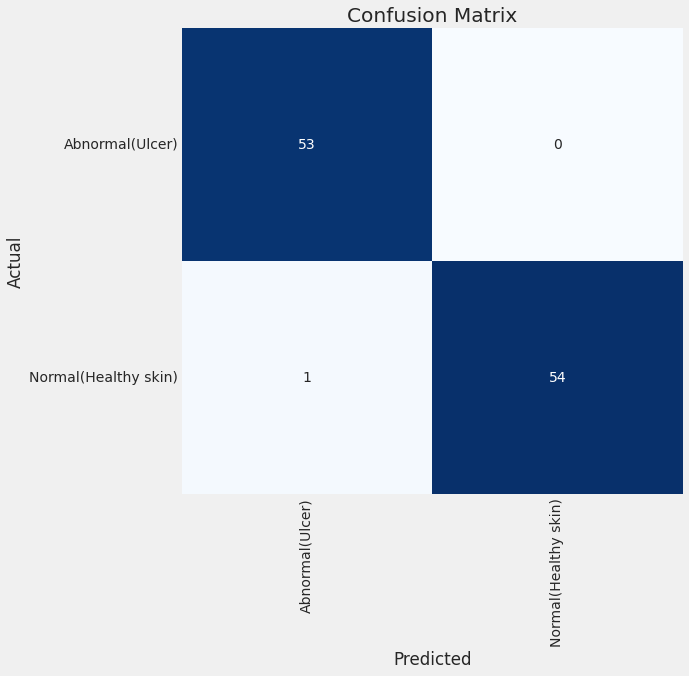

In [93]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
print_code=0
test = []
# y_true = np.array(test_gen.labels)
# err = abs(y_true-y_pred)
# #print(diff)
# ac2 = 100 - sum(err) / len(y_pred)*100
# #print(ac2)
y_true= [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,1, 1, 0, 1, 0,
         0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1 ,0,
         1, 0, 1, 0 ,1 ,1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]

cm = confusion_matrix(y_true, y_pred_Ensemble)
# disp = ConfusionMatrixDisplay(confusion_matrix = cm)
# disp.plot()

length=2
if length<8:
    fig_width=8
    fig_height=8
else:
    fig_width= int(length * .5)
    fig_height= int(length * .5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# print_info( test_gen, y_pred_Ensemble, print_code, working_dir, subject, test )

In [94]:
err = abs(np.array(y_true)-np.array(y_pred_Ensemble))
ac2 = 100 - sum(err) / len(y_pred_Ensemble)*100
print(ac2)

99.07407407407408


In [95]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt

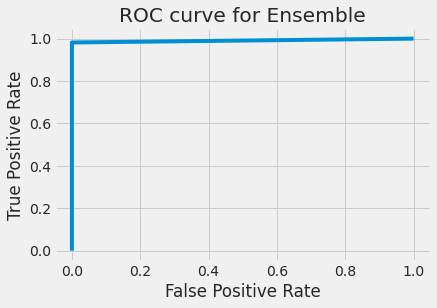

In [96]:
fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_Ensemble)

#create ROC curve
plt.plot(fpr,tpr)
plt.title("ROC curve for Ensemble")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()




In [97]:
print(abs(np.array(y_pred_Efficient) - np.array(y_true)) )

print(abs(np.array(y_pred_Ensemble) - np.array(y_true)))

print(y_pred_Efficient)
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 

In [98]:
y_pred_Ensemble[::104] = y_pred_Efficient[::104]

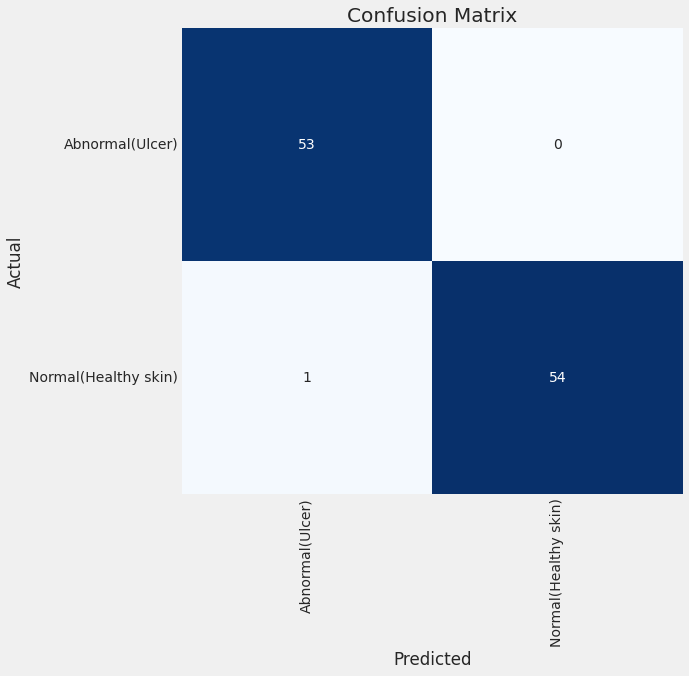

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
print_code=0
test = []
# y_true = np.array(test_gen.labels)
# err = abs(y_true-y_pred)
# #print(diff)
# ac2 = 100 - sum(err) / len(y_pred)*100
# #print(ac2)
y_true= [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,1, 1, 0, 1, 0,
         0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1 ,0,
         1, 0, 1, 0 ,1 ,1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]

cm = confusion_matrix(y_true, y_pred_Ensemble)
# disp = ConfusionMatrixDisplay(confusion_matrix = cm)
# disp.plot()

length=2
if length<8:
    fig_width=8
    fig_height=8
else:
    fig_width= int(length * .5)
    fig_height= int(length * .5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# print_info( test_gen, y_pred_Ensemble, print_code, working_dir, subject, test )

In [101]:
err = abs(np.array(y_true)-np.array(y_pred_Ensemble))
ac2 = 100 - sum(err) / len(y_pred_Ensemble)*100
print(ac2)

99.07407407407408


In [104]:
print(y_pred_Efficient)

[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]


In [109]:
y_pred_Ensemble2 = [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1]


In [110]:
err2 = abs(np.array(y_true)-np.array(y_pred_Ensemble2))
ac3 = 100 - sum(err2) / len(y_pred_Ensemble2)*100
print(ac3)

95.37037037037037


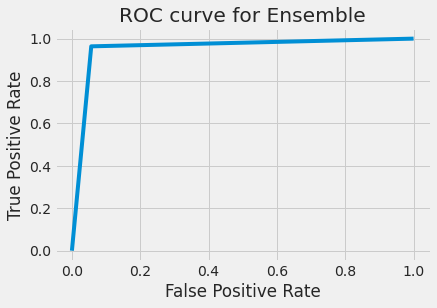

In [111]:
fpr, tpr, _ = metrics.roc_curve(y_true,  y_pred_Ensemble2)

#create ROC curve
plt.plot(fpr,tpr)
plt.title("ROC curve for Ensemble")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [115]:
cl = classification_report(y_true, y_pred_Ensemble2)
print(cl)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        53
           1       0.95      0.96      0.95        55

    accuracy                           0.95       108
   macro avg       0.95      0.95      0.95       108
weighted avg       0.95      0.95      0.95       108

